In [ ]:
# Cell 1: Import Libraries
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
import os
import urllib.request
import pickle
import kagglehub
from datetime import datetime


# Generate pics folder


In [ ]:
def save_processed_data(images, labels, label_map, save_dir='processed_data'):
    """
    Save the processed images in separate folders by person, along with metadata.

    Args:
        images (np.array): Processed face images.
        labels (np.array): Corresponding labels.
        label_map (dict): Mapping of label indices to person names.
        save_dir (str): Directory to save the processed data.
    """
    # Create main save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Save each person's images in their respective folder
    for label, person_name in label_map.items():
        # Create a directory for each person
        person_dir = os.path.join(save_dir, person_name)
        os.makedirs(person_dir, exist_ok=True)

        # Find indices for images corresponding to the current person
        person_indices = [i for i, lbl in enumerate(labels) if lbl == label]

        for idx in person_indices:
            img = images[idx]
            # Generate a unique filename for each image
            filename = f'{person_name}_{idx}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.jpg'
            filepath = os.path.join(person_dir, filename)

            # Convert image back to uint8 for saving
            img_uint8 = (img * 255).astype('uint8')
            cv2.imwrite(filepath, img_uint8)
            print(f"Saved {filepath}")

    # Save metadata for easy loading
    metadata = {
        'label_map': label_map,
        'n_images': len(images),
        'n_classes': len(label_map)
    }

    # Save metadata in the main directory
    with open(os.path.join(save_dir, 'metadata.pkl'), 'wb') as f:
        pickle.dump(metadata, f)

    print("All images saved successfully with metadata.")


def load_processed_data(filepath=None, data_dir='processed_data'):
    """
    Load previously processed data from disk

    Args:
        filepath (str, optional): Specific file to load. If None, loads the latest file
        data_dir (str): Directory containing the processed data

    Returns:
        tuple: (images, labels, label_map)
    """
    if filepath is None:
        # Load metadata to get the latest file
        metadata_path = os.path.join(data_dir, 'metadata.pkl')
        if not os.path.exists(metadata_path):
            raise FileNotFoundError("No metadata file found. Please process the data first.")

        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
        filepath = metadata['latest_file']

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}")

    print(f"Loading data from: {filepath}")
    with open(filepath, 'rb') as f:
        data = pickle.load(f)

    return data['images'], data['labels'], data['label_map']

# Download files
- deploy.prototxt
- res10_300x300_ssd_iter_140000.caffemodel


In [ ]:
def download_model_files(model_dir='face_detection_model'):
    """
    Download the necessary model files for face detection if they are not already present.
    Verifies the download by checking file size.
    """
    os.makedirs(model_dir, exist_ok=True)
    prototxt_url = 'https://github.com/Alsafy01/Deep-Learning/raw/main/Lab3%20Bonus/deploy.prototxt'
    caffemodel_url = 'https://github.com/Alsafy01/Deep-Learning/raw/main/Lab3%20Bonus/res10_300x300_ssd_iter_140000.caffemodel'

    prototxt_path = os.path.join(model_dir, 'deploy.prototxt')
    caffemodel_path = os.path.join(model_dir, 'res10_300x300_ssd_iter_140000.caffemodel')

    # Expected sizes in bytes (approximately)
    expected_prototxt_size = 2000  # 2 KB
    expected_caffemodel_size = 10400000  # 10 MB

    # Download files if they don't exist
    if not os.path.exists(prototxt_path):
        print(f"Downloading {prototxt_url}...")
        urllib.request.urlretrieve(prototxt_url, prototxt_path)

    if not os.path.exists(caffemodel_path):
        print(f"Downloading {caffemodel_url}...")
        urllib.request.urlretrieve(caffemodel_url, caffemodel_path)

    # Verify file sizes to ensure downloads are correct
    if (os.path.getsize(prototxt_path) < expected_prototxt_size or
        os.path.getsize(caffemodel_path) < expected_caffemodel_size):
        raise ValueError("Downloaded model files are incomplete or corrupted. Please try downloading again.")

    print("Model files downloaded and verified successfully.")
    return prototxt_path, caffemodel_path


# crop faces function

In [ ]:
def load_and_preprocess_data(save_dir='processed_data', force_reprocess=False, expected_images_per_person=100):
    """
    Load and preprocess images from the dataset, saving each person's images in a separate folder.
    Skips reprocessing if the folder is already complete.

    Args:
        save_dir (str): Directory to save/load processed data.
        force_reprocess (bool): If True, reprocess all data even if folders exist.
        expected_images_per_person (int): Number of expected images per person for skipping purposes.

    Returns:
        dict: label_map mapping label indices to person names.
    """
    # Check for existing processed data
    if not force_reprocess and os.path.exists(save_dir):
        try:
            return load_processed_data(data_dir=save_dir)
        except Exception as e:
            print(f"Error loading cached data: {e}")
            print("Proceeding with data processing...")

    # Download dataset
    print("Downloading dataset...")
    dataset_path = kagglehub.dataset_download("hereisburak/pins-face-recognition")
    print("Dataset downloaded to:", dataset_path)

    # Find the main dataset directory
    main_dir = None
    for item in os.listdir(dataset_path):
        if "105_classes_pins_dataset" in item:
            main_dir = os.path.join(dataset_path, item)
            break

    if main_dir is None:
        raise Exception("Could not find the main dataset directory")

    # Initialize label_map to store person names
    label_map = {}
    current_label = 0

    # Download and load face detection model
    prototxt_path, caffemodel_path = download_model_files()
    face_net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

    # Walk through the person directories (prefixed with "pins_")
    for folder_index, person_dir in enumerate(sorted(os.listdir(main_dir))):
        if person_dir.startswith('pins_'):
            person_name = person_dir[5:]  # Remove 'pins_' prefix
            person_path = os.path.join(main_dir, person_dir)

            # Check if this person's folder already exists in the save directory and is complete
            person_save_dir = os.path.join(save_dir, person_name)
            if os.path.exists(person_save_dir):
                existing_images = len([img for img in os.listdir(person_save_dir) if img.endswith('.jpg')])
                if existing_images >= expected_images_per_person:
                    print(f"Skipping {person_name}, already processed with {existing_images} images.")
                    label_map[current_label] = person_name
                    current_label += 1
                    continue  # Skip this person if the folder is complete

            # Print the folder index before processing
            print(f"Processing folder {folder_index + 1}: {person_name}")
            label_map[current_label] = person_name
            os.makedirs(person_save_dir, exist_ok=True)

            for img_name in os.listdir(person_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(person_path, img_name)

                    # Read and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read image {img_path}")
                        continue

                    # Face detection
                    (h, w) = img.shape[:2]
                    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
                                                 (300, 300), (104.0, 177.0, 123.0))
                    face_net.setInput(blob)
                    detections = face_net.forward()

                    # Get the face with the highest confidence
                    max_conf = 0
                    max_face = None

                    for i in range(detections.shape[2]):
                        confidence = detections[0, 0, i, 2]
                        if confidence > 0.5:  # Minimum confidence threshold
                            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                            (startX, startY, endX, endY) = box.astype("int")

                            # Ensure coordinates are within image bounds
                            startX, startY = max(0, startX), max(0, startY)
                            endX, endY = min(w, endX), min(h, endY)

                            # Extract and preprocess face
                            face = img[startY:endY, startX:endX]
                            if face.size == 0:
                                continue

                            face = cv2.resize(face, (224, 224))  # Assuming IMG_SIZE = 224
                            if confidence > max_conf:
                                max_conf = confidence
                                max_face = face

                    if max_face is not None:
                        # Normalize pixel values
                        max_face = (max_face.astype('float32') / 255.0)

                        # Save each image to the person's folder with a unique name
                        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                        img_filename = f"{person_name}_{timestamp}_{img_name}"
                        img_filepath = os.path.join(person_save_dir, img_filename)

                        # Convert back to uint8 for saving
                        cv2.imwrite(img_filepath, (max_face * 255).astype('uint8'))

            print(f"Processed all images for {person_name}")
            current_label += 1

    # Save the label map as metadata
    with open(os.path.join(save_dir, 'metadata.pkl'), 'wb') as f:
        pickle.dump(label_map, f)
    print("Label map saved successfully as metadata.")

    return label_map


In [ ]:
# Load and preprocess data
print("Loading and preprocessing data...")
label_map = load_and_preprocess_data(save_dir="/content/drive/MyDrive/processed_data")
print(f"Data contains {len(label_map)} unique labels.")

Loading and preprocessing data...


100%|██████████| 372M/372M [00:03<00:00, 114MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/hereisburak/pins-face-recognition/versions/1
Model files downloaded and verified successfully.
Processing folder 1: Adriana Lima
Processed all images for Adriana Lima
Processing folder 2: Alex Lawther
Processed all images for Alex Lawther
Processing folder 3: Alexandra Daddario
Processed all images for Alexandra Daddario
Processing folder 4: Alvaro Morte
Processed all images for Alvaro Morte
Processing folder 5: Amanda Crew
Processed all images for Amanda Crew
Processing folder 6: Andy Samberg
Processed all images for Andy Samberg
Processing folder 7: Anne Hathaway
Processed all images for Anne Hathaway
Processing folder 8: Anthony Mackie
Processed all images for Anthony Mackie
Processing folder 9: Avril Lavigne
Processed all images for Avril Lavigne
Processing folder 10: Ben Affleck
Processed all images for Ben Affleck
Processing folder 11: Bill Gates
Processed all images for Bill Gates
Processing folder 12: Bobby Morley
Processed

In [ ]:
# Load metadata for label_map
with open('/content/drive/MyDrive/processed_data/metadata.pkl', 'rb') as f:
    label_map = pickle.load(f)

# Parameters
input_shape = (224, 224, 3)
num_classes = len(label_map)

# Data Generators for Training and Validation
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/processed_data',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/processed_data',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 14070 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


# model V1
- so slow

In [ ]:
def create_model(base_model_name="ResNet50", num_classes=num_classes):
    # Load the base pre-trained model
    if base_model_name == "VGG16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "InceptionV3":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Regularization
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)  # Regularization
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_model(base_model_name="VGG16", num_classes=num_classes)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,923,113 (60.74 MB)

 Trainable params: 1,208,425 (4.61 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=30)


Epoch 1/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.0115 - loss: 4.6604 - val_accuracy: 0.0292 - val_loss: 4.5077
Epoch 2/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - accuracy: 0.0259 - loss: 4.4560 - val_accuracy: 0.0384 - val_loss: 4.2421
Epoch 3/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - accuracy: 0.0393 - loss: 4.2149 - val_accuracy: 0.0566 - val_loss: 4.0601
Epoch 4/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - accuracy: 0.0553 - loss: 4.0448 - val_accuracy: 0.0826 - val_loss: 3.9292
Epoch 5/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - accuracy: 0.0783 - loss: 3.9050 - val_accuracy: 0.1016 - val_loss: 3.7952
Epoch 6/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - accuracy: 0.1026 - loss: 3.7721 - val_accuracy: 0.1265 - val_loss: 3.6755
Epoch 7/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 89s 90ms/step - accuracy: 0.1201 - loss: 3.6692 - val_accuracy: 0.1366 - val_loss: 3.5729
Epoch 8/30
880/880 ━━━━━━━━━━━━━━━━━━━━ 79s 90ms/step - accuracy: 0.1445 - loss: 3.5307 - 

217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.3521 - loss: 2.5684
Validation Accuracy: 35.86%


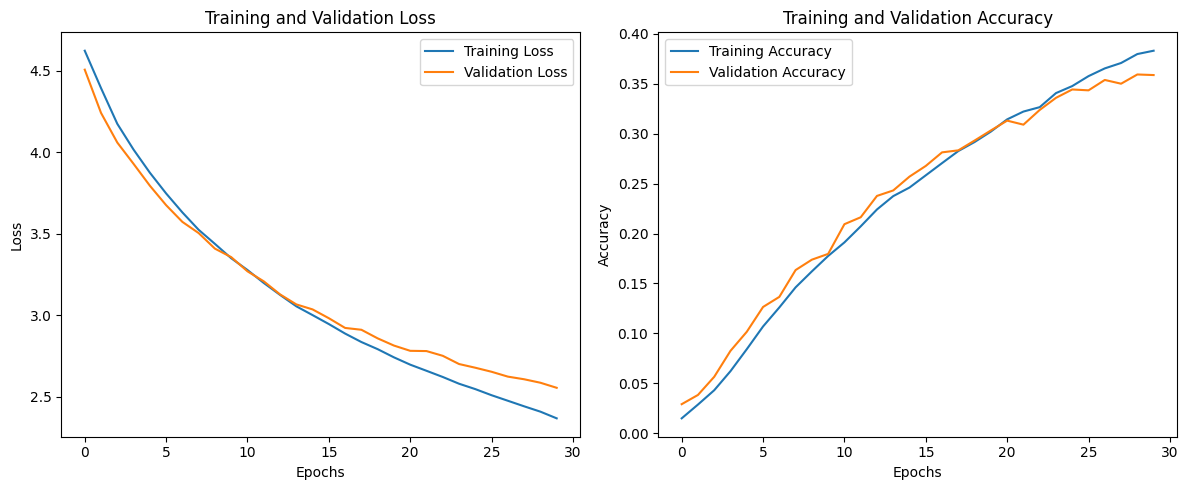

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss on the first subplot
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Training and Validation Loss')

# Plot training and validation accuracy on the second subplot
ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title('Training and Validation Accuracy')

# Show the combined plot
plt.tight_layout()
plt.show()

# model V2
- still slow
- but promising to get accuarcy more than 0.4684

In [ ]:
from sklearn.preprocessing import LabelEncoder
import gc
from pathlib import Path

class CustomDataGenerator:
    def __init__(self, data_dir, batch_size, label_encoder, image_size=(224, 224)):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.image_size = image_size
        self.label_encoder = label_encoder

        # Get all image paths and labels
        self.image_paths = []
        self.labels = []

        for person_folder in self.data_dir.iterdir():
            if person_folder.is_dir():
                for img_path in person_folder.glob('*.jpg'):
                    self.image_paths.append(str(img_path))
                    self.labels.append(person_folder.name)

        self.indices = np.arange(len(self.image_paths))
        self.num_samples = len(self.image_paths)

    def preprocess_image(self, img_path):
        """Load and preprocess a single image"""
        img = cv2.imread(img_path)
        if img is None:
            return None
        img = cv2.resize(img, self.image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        return img

    def generate_batches(self, shuffle=True):
        """Generate batches of preprocessed images"""
        while True:
            if shuffle:
                np.random.shuffle(self.indices)

            for start_idx in range(0, self.num_samples, self.batch_size):
                batch_indices = self.indices[start_idx:start_idx + self.batch_size]
                batch_paths = [self.image_paths[i] for i in batch_indices]
                batch_labels = [self.labels[i] for i in batch_indices]

                # Initialize batch arrays
                batch_images = []
                valid_labels = []

                # Load and preprocess images
                for img_path, label in zip(batch_paths, batch_labels):
                    img = self.preprocess_image(img_path)
                    if img is not None:
                        batch_images.append(img)
                        valid_labels.append(label)

                if not batch_images:  # Skip empty batches
                    continue

                # Convert to numpy arrays
                X = np.array(batch_images)
                y = self.label_encoder.transform(valid_labels)
                y = tf.keras.utils.to_categorical(y, len(self.label_encoder.classes_))

                yield X, y

class FaceRecognitionSystem:
    def __init__(self):
        self.recognition_model = None
        self.label_encoder = LabelEncoder()
        self.similarity_threshold = 0.6

    def setup_model(self, num_classes):
        """Initialize the model architecture"""
        # Clear any existing models from memory
        tf.keras.backend.clear_session()
        gc.collect()

        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        x = base_model.output
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(512, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        self.recognition_model = Model(inputs=base_model.input, outputs=predictions)

        self.recognition_model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def prepare_labels(self, data_dir):
        """Prepare label encoder without loading images"""
        person_names = []
        for person_folder in Path(data_dir).iterdir():
            if person_folder.is_dir():
                person_names.append(person_folder.name)

        self.label_encoder.fit(person_names)
        return len(self.label_encoder.classes_)

    def train_model(self, processed_data_dir, epochs=20, batch_size=16):
        """Train the face recognition model using generators"""
        print("Preparing dataset...")
        num_classes = self.prepare_labels(processed_data_dir)

        # Setup model if not already done
        if self.recognition_model is None:
            print(f"Setting up model with {num_classes} classes...")
            self.setup_model(num_classes)

        # Create data generator
        data_gen = CustomDataGenerator(
            processed_data_dir,
            batch_size,
            self.label_encoder
        )

        # Count total samples for steps calculation
        total_samples = len(data_gen.image_paths)
        steps_per_epoch = total_samples // batch_size

        print(f"Total samples: {total_samples}")
        print(f"Steps per epoch: {steps_per_epoch}")

        # Train the model
        print("Starting training...")
        history = self.recognition_model.fit(
            data_gen.generate_batches(),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            verbose=1
        )

        return history

    def process_live_stream(self):
        """Process live video stream for face detection and recognition"""
        try:
            face_detector = cv2.dnn.readNet(
                "deploy.prototxt",
                "res10_300x300_ssd_iter_140000.caffemodel"
            )
        except Exception as e:
            print(f"Error loading face detector: {e}")
            return

        print("Starting video capture...")
        cap = cv2.VideoCapture(0)

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame
            try:
                height, width = frame.shape[:2]
                blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123])
                face_detector.setInput(blob)
                detections = face_detector.forward()

                for i in range(detections.shape[2]):
                    confidence = detections[0, 0, i, 2]
                    if confidence > 0.5:
                        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                        x1, y1, x2, y2 = box.astype(int)

                        if y2 - y1 > 0 and x2 - x1 > 0:  # Check valid box dimensions
                            face_img = frame[y1:y2, x1:x2]
                            face_img = cv2.resize(face_img, (224, 224))
                            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                            face_img = tf.keras.applications.vgg16.preprocess_input(face_img)

                            prediction = self.recognition_model.predict(
                                np.expand_dims(face_img, axis=0),
                                verbose=0
                            )

                            class_idx = np.argmax(prediction[0])
                            confidence = prediction[0][class_idx]

                            if confidence > self.similarity_threshold:
                                person_name = self.label_encoder.inverse_transform([class_idx])[0]
                                label = f"{person_name}: {confidence:.2f}"
                            else:
                                label = "Unknown"

                            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                            cv2.putText(frame, label, (x1, y1-10),
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                cv2.imshow('Face Recognition', frame)

            except Exception as e:
                print(f"Error processing frame: {e}")
                continue

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    def save_model(self, save_dir):
        """Save the trained model and label encoder"""
        save_dir = Path(save_dir)
        save_dir.mkdir(exist_ok=True)

        self.recognition_model.save(str(save_dir / 'face_recognition_model.h5'))
        np.save(str(save_dir / 'label_encoder_classes.npy'), self.label_encoder.classes_)
        print(f"Model and label encoder saved to {save_dir}")

    def load_model(self, save_dir):
        """Load a trained model and label encoder"""
        save_dir = Path(save_dir)

        # Clear existing model from memory
        tf.keras.backend.clear_session()
        gc.collect()

        self.recognition_model = tf.keras.models.load_model(str(save_dir / 'face_recognition_model.h5'))
        self.label_encoder.classes_ = np.load(str(save_dir / 'label_encoder_classes.npy'))
        print(f"Model and label encoder loaded from {save_dir}")

In [ ]:
# Initialize the system
face_system = FaceRecognitionSystem()

# Train the model
history = face_system.train_model(
    processed_data_dir='/content/drive/MyDrive/processed_data',
    epochs=20,
    batch_size=32
)

# Save the trained model
face_system.save_model('face_recognition_model.h5')

# Later, you can load the model and run live recognition
face_system.load_model('face_recognition_model.h5')
face_system.process_live_stream()

Preparing dataset...
Setting up model with 105 classes...
Total samples: 17812
Steps per epoch: 556
Starting training...
Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 293s 511ms/step - accuracy: 0.0127 - loss: 4.8302
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 291s 518ms/step - accuracy: 0.0559 - loss: 4.1677
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 287s 516ms/step - accuracy: 0.2786 - loss: 2.8583
Epoch 4/20
 62/556 ━━━━━━━━━━━━━━━━━━━━ 4:13 513ms/step - accuracy: 0.4684 - loss: 1.9713

- It have the potential to score between 70-80% accuarcy.
- there's no enought resources to run the model  